In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import pycountry
import plotly.express as px

In [3]:
# Obtener la página
url = "https://data.worldobesity.org/tables/prevalence-of-adult-overweight-obesity-2/?regionid=-1&incomegroupid=-1&msr=msr&breakdown=c"
page = requests.get(url).text
soup = bs(page)

In [4]:
# Saber cuantas tablas tiene la página
tables = soup.find_all('table')
len(tables)

1

In [5]:
# Buscar la que tiene los datos
tables[0]

<table class="results" id="results"><thead><tr><th class="sorttable_sorted">Country</th><th class="nosort">Income group</th><th class="">Year</th><th class="">Area</th><th class="">Age</th><th class="">Males<br/>Overweight<br/>(BMI 25-29.9kg/m²)</th><th class="">Males<br/>Obesity<br/>(BMI ≥30kg/m²)</th><th class="">Females<br/>Overweight<br/>(BMI 25-29.9kg/m²)</th><th class="">Females<br/>Obesity<br/>(BMI ≥30kg/m²)</th><th class="">All adults<br/>Overweight<br/>(BMI 25-29.9kg/m²)</th><th class="">All adults<br/>Obesity<br/>(BMI ≥30kg/m²)</th></tr></thead><tbody><tr><td><span class="flag" style="background-image:url('gfx/flags-iso/AF.svg');"></span>Afghanistan</td><td>Low income</td><td>2018</td><td>National</td><td class="agebox">18-69</td><td>25.90</td><td>11.90</td><td>25.60</td><td>23.50</td><td>25.80</td><td>17.00</td></tr><tr class="selfreport"><td><span class="flag" style="background-image:url('gfx/flags-iso/AL.svg');"></span>Albania</td><td>Upper-middle income</td><td>2022</td><

In [6]:
# Convertir a una DataFrame
df = pd.DataFrame(columns = [
        'Country',
        'Year',
        'Age',
        'All_adults_Overweight',
        'All_adults_Obesity'
    ])

for row in tables[0].find_all('tr')[1::]:
    cols = row.find_all("td")
    cols = [col.text.strip() for col in cols]
    new_row = pd.DataFrame(
        {
            'Country': cols[0],
            'Year': cols[2],
            'Age': cols[4],
            'All_adults_Overweight': cols[9],
            'All_adults_Obesity': cols[10]
        },
        index=['country']
    )
    df = pd.concat([df, new_row], ignore_index=True)

In [7]:
# Códigos estándar de países y manejo de nulls

df.iloc[:, :2] = df.iloc[:, :2].replace('', np.nan)
df.iloc[:, 3:] = df.iloc[:, 3:].replace('-', np.nan)

cols = [
    'All_adults_Overweight',
    'All_adults_Obesity'
]
for col in cols:
    df[col] = df[col].astype(float)

def country_to_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except:
        return None
    
df["iso_alpha"] = df["Country"].apply(country_to_iso3)

col = df.pop("iso_alpha")
df.insert(1, "iso_alpha", col)
df

,Country,iso_alpha,Year,Age,All_adults_Overweight,All_adults_Obesity
0,Afghanistan,AFG,2018,18-69,25.8,17.0
1,Albania,ALB,2022,16+,44.2,12.4
2,Algeria,DZA,2016-2017,18-69,33.8,21.8
3,American Samoa,ASM,2017-2018,18+,NaN,80.2
4,Andorra,AND,2017-2018,18-75,35.2,13.6
...,...,...,...,...,...,...
243,Wales,None,2022-2023,16+,35.2,26.0
244,Wallis and Futuna,WLF,2019,18-69,20.0,70.4
245,Yemen,YEM,2013,15-49,NaN,NaN
246,Zambia,ZMB,2017,18-69,16.7,7.5


In [8]:
diabetes = pd.read_csv("diabetes_2024.csv", sep=",")
diabetes = diabetes[["Country Code", "2024"]]
diabetes

,Country Code,2024
0,ABW,4.600000
1,AFE,6.454392
2,AFG,11.700000
3,AFW,4.219277
4,AGO,4.900000
...,...,...
261,XKX,10.400000
262,YEM,5.500000
263,ZAF,7.200000
264,ZMB,10.300000


In [15]:
df_completo = df.merge(diabetes, "left", left_on="iso_alpha", right_on="Country Code")
df_completo = df_completo.drop(["Country Code"], axis=1)
df_completo = df_completo.rename(
    columns={
        "2024": "All_adults_Diabetes"
        }
)
df_completo

,Country,iso_alpha,Year,Age,All_adults_Overweight,All_adults_Obesity,All_adults_Diabetes
0,Afghanistan,AFG,2018,18-69,25.8,17.0,11.7
1,Albania,ALB,2022,16+,44.2,12.4,10.6
2,Algeria,DZA,2016-2017,18-69,33.8,21.8,17.5
3,American Samoa,ASM,2017-2018,18+,NaN,80.2,NaN
4,Andorra,AND,2017-2018,18-75,35.2,13.6,10.1
...,...,...,...,...,...,...,...
243,Wales,None,2022-2023,16+,35.2,26.0,NaN
244,Wallis and Futuna,WLF,2019,18-69,20.0,70.4,NaN
245,Yemen,YEM,2013,15-49,NaN,NaN,5.5
246,Zambia,ZMB,2017,18-69,16.7,7.5,10.3


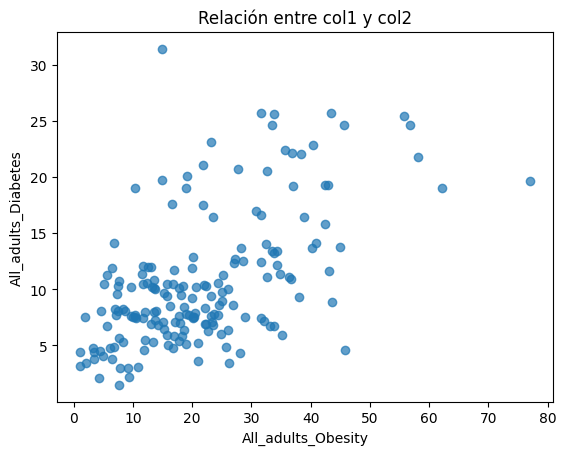

In [18]:
import matplotlib.pyplot as plt

# Scatter plot entre dos columnas
plt.scatter(df_completo["All_adults_Obesity"], df_completo["All_adults_Diabetes"], alpha=0.7)
plt.xlabel("All_adults_Obesity")
plt.ylabel("All_adults_Diabetes")
plt.title("Relación entre col1 y col2")
plt.show()


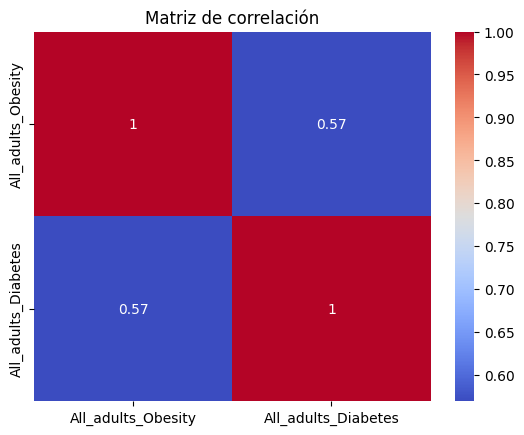

In [19]:
import seaborn as sns

sns.heatmap(df_completo[["All_adults_Obesity", "All_adults_Diabetes"]].corr(), annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

In [20]:
corr = df_completo["All_adults_Obesity"].corr(df_completo["All_adults_Diabetes"])
print("Coeficiente de correlación:", corr)

Coeficiente de correlación: 0.5691606367962866


In [ ]:
df_completo["ratio"] = df_completo["All_adults_Obesity"] / df_completo["All_adults_Diabetes"]
df_completo["ratio_norm"] = 2 * ((ratio - ratio.min()) / (ratio.max() - ratio.min())) - 1
df_completo

,Country,iso_alpha,Year,Age,All_adults_Overweight,All_adults_Obesity,All_adults_Diabetes,ratio
0,Afghanistan,AFG,2018,18-69,25.8,17.0,11.7,1.452991
1,Albania,ALB,2022,16+,44.2,12.4,10.6,1.169811
2,Algeria,DZA,2016-2017,18-69,33.8,21.8,17.5,1.245714
3,American Samoa,ASM,2017-2018,18+,NaN,80.2,NaN,NaN
4,Andorra,AND,2017-2018,18-75,35.2,13.6,10.1,1.346535
...,...,...,...,...,...,...,...,...
243,Wales,None,2022-2023,16+,35.2,26.0,NaN,NaN
244,Wallis and Futuna,WLF,2019,18-69,20.0,70.4,NaN,NaN
245,Yemen,YEM,2013,15-49,NaN,NaN,5.5,NaN
246,Zambia,ZMB,2017,18-69,16.7,7.5,10.3,0.728155


In [27]:
ratio = df_completo["All_adults_Obesity"] / df_completo["All_adults_Diabetes"]

# Normalización al rango [-1, 1]
df_completo["ratio_norm"] = 2 * ((ratio - ratio.min()) / (ratio.max() - ratio.min())) - 1
df_completo


,Country,iso_alpha,Year,Age,All_adults_Overweight,All_adults_Obesity,All_adults_Diabetes,ratio,ratio_norm
0,Afghanistan,AFG,2018,18-69,25.8,17.0,11.7,1.452991,-0.748034
1,Albania,ALB,2022,16+,44.2,12.4,10.6,1.169811,-0.806246
2,Algeria,DZA,2016-2017,18-69,33.8,21.8,17.5,1.245714,-0.790643
3,American Samoa,ASM,2017-2018,18+,NaN,80.2,NaN,NaN,NaN
4,Andorra,AND,2017-2018,18-75,35.2,13.6,10.1,1.346535,-0.769918
...,...,...,...,...,...,...,...,...,...
243,Wales,None,2022-2023,16+,35.2,26.0,NaN,NaN,NaN
244,Wallis and Futuna,WLF,2019,18-69,20.0,70.4,NaN,NaN,NaN
245,Yemen,YEM,2013,15-49,NaN,NaN,5.5,NaN,NaN
246,Zambia,ZMB,2017,18-69,16.7,7.5,10.3,0.728155,-0.897036


In [10]:
# Guardar en Json
df_completo.to_json("datos.json", orient="records", force_ascii=False, indent=2)

In [29]:
# Ejmplo usando plotly

fig = px.choropleth(
    df_completo,
    locations="iso_alpha",
    locationmode="ISO-3",
    color="ratio",
    color_continuous_scale="Viridis",
    title="Mapa de calor mundial"
)
fig.show()